In [181]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, inv

from utils import load_data, visualize_trajectory_2d, show_result, compare_result

In [537]:
filename = "./data/0027.npz"
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)

In [538]:
print(t.shape,features.shape,linear_velocity.shape,rotational_velocity.shape)

(1, 1106) (4, 206, 1106) (3, 1106) (3, 1106)


## IMU Localization via EKF Prediction

In [187]:
def hat_map(w):
    '''
    Transform w in R3 to w_hat in R3x3
    '''
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    w_hat = np.zeros([3,3])
    w_hat[0,1] = -w3
    w_hat[0,2] = w2
    w_hat[1,0] = w3
    w_hat[1,2] = -w1
    w_hat[2,0] = -w2
    w_hat[2,1] = w1
    return(w_hat)

def twist(v,w):
    '''
    Map u= [v,w]^T in R6x1 to se(3) in 4x4
    '''
    twist = np.zeros([4,4])
    twist[:3,:3] = hat_map(w)
    twist[:3,3] = v
    return twist

def u_ad(v,w):
    '''
    v in R3 
    w in R3 
    u_ad R6x6
    '''
    v_hat = hat_map(v)
    w_hat = hat_map(w)
    u_ad = np.zeros([6,6])
    u_ad[:3,:3] = w_hat
    u_ad[-3:,-3:] = w_hat
    u_ad[:3,-3:] = w_hat
    return u_ad

def rog_3(v,w):
    '''
    u = [v,w]T
    Rodrigues for u where u is 6x1
    '''
    u_se3 = twist(v,w) # get se3
    u2 = np.dot(u_se3,u_se3) # u*u
    u3 = np.dot(u2,u_se3) # u*u*u
    u2_term = u2* (1-np.cos(norm(w)))/(np.square(norm(w)))
    u3_term = u3 * (norm(w)-np.sin(norm(w)))/np.power(norm(w),3)
    T = np.eye(4) + u_se3 + u2_term + u3_term
    return T

def rog_3_approx(v,w):
    '''
    u = [v,w]T
    Rodrigues for u where u is 6x1 using only order 1 term
    '''
    u_se3 = twist(v,w) # get se3
    T = np.eye(4) + u_se3 
    return T

def rog_6(v,w):
    u1 = u_ad(v,w)
    u2 = np.dot(u1,u1)
    u3 = np.dot(u2,u1)
    u4 = np.dot(u3,u1)
    w_n = norm(w)
    u1_coef = (3*np.sin(w_n)-w_n*np.cos(w_n))/(2*w_n)
    u2_coef = (4-w_n*np.sin(w_n)-4*np.cos(w_n))/(2*w_n*w_n)
    u3_coef = (np.sin(w_n)-w_n*np.cos(w_n))/(2*np.power(w_n,3))
    u4_coef = (2-w_n*np.sin(w_n)-2*np.cos(w_n))/(2*np.power(w_n,4))
    T = np.eye(6)+ u1_coef*u1 + u2_coef*u2 + u3_coef*u3 + u4_coef*u4
    return T

# Predicat mean and covariance
def mean_predict(mu,tau,v,w):
    '''
    EKF Mean Prediction
    '''
    p = -tau * v
    theta = -tau * w
    mu_new = np.dot(rog_3(p,theta),mu)
    return mu_new

def cov_pred(cov,tau,v,w,W_noise):
    p = -tau * v
    theta = -tau * w
    T = rog_6(p,theta)
    cov_new = np.dot(T,cov)
    cov_new = np.dot(cov_new,np.transpose(T))
    cov_new = cov_new + W_noise * tau * tau
    return cov_new

In [188]:
def imu_predict(t,v,w,w_scale = 10e-10):
    '''
    get trajectory on xy-plane using EKF prediction
    total points = n
    v,w has shape 3*(n+1)
    '''
    # get tau from timestamps
    tau = t[:,1:]-t[:,:-1]
    n = tau.shape[1]
    # discard v,w at time 0
    v = v[:,1:]
    w = w[:,1:]
    # initialize mu and cov and noise
    mu = np.eye(4)
    cov = np.eye(6)
    W_noise = np.eye(6) * w_scale
    # store poses
    pose = np.zeros([4,4,n+1])
    pose_inv = np.zeros([4,4,n+1])
    pose[:,:,0] = mu
    pose_inv[:,:,0] = inv(mu)
    for i in range(n):
        # get current v,w,tau
        w_noise = np.random.normal(0, np.sqrt(w_scale)) # noise
        v_c = v[:,i] + w_noise
        w_c = w[:,i] + w_noise
        t_c = tau[:,i]
        mu = mean_predict(mu,t_c,v_c,w_c)
        cov = cov_pred(cov,t_c,v_c,w_c,W_noise)
        pose[:,:,i+1] = mu
        pose_inv[:,:,i+1] = inv(mu)
    return pose, pose_inv

In [543]:
iTw, wTi = imu_predict(t,linear_velocity,rotational_velocity,10e-7)

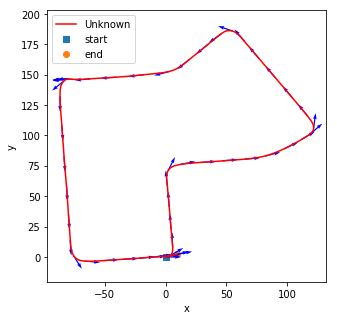

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f283d68>)

In [544]:
visualize_trajectory_2d(wTi,show_ori=True)

## Landmark Mapping vis EKF Update

In [497]:
def p_to_w(uv,K,b,oTi,iTw):
    '''
    solve stero camera inverse M to get homogeneous coordinates xyz in world frame from left right pixels
    '''
    ul,vl,ur,vr = uv
    fsu = K[0,0]
    fsv = K[1,1]
    cu = K[0,2]
    cv = K[1,2]
    z = fsu * b /(ul-ur)
    x = z*(ul-cu)/fsu
    y = z*(vl-cv)/fsv
    m_o = np.array([x,y,z,1]).reshape([4,1])
    m_i = np.dot(inv(oTi),m_o)
    m_w = np.dot(inv(iTw),m_i)
    return m_w

def projection(q):
    '''
    Get the projection of a vector in R4
    '''
    pi = q/q[2]
    return pi

def proj_deriv(q):
    '''
    Take a R4 vector and return the derivative of its projection function
    '''
    der = np.zeros([4,4])
    der[0,0] = 1
    der[1,1] = 1
    der[3,3] = 1
    der[0,2] = -q[0]/q[2]
    der[1,2] = -q[1]/q[2]
    der[3,2] = -q[3]/q[2]
    der = der / q[2]
    return der

def calibration(K,b):
    '''
    Obtain the calibration matrix M from K and b
    '''
    M = np.vstack([K[:2],K[:2]])
    c = np.array([0,0,-K[0,0]*b,0]).reshape([4,1])
    M = np.hstack([M,c])
    return M

def get_Kt(cov,Ht,v):
    V_noise = np.eye(Ht.shape[0])*v
    inv_term = np.dot(Ht,cov.dot(np.transpose(Ht)))+V_noise
    Kt = np.dot(cov.dot(np.transpose(Ht)),inv(inv_term))
    return Kt

def visual_mapping(features,iTw, K,b,cam_T_imu, v_scale = 100):
    oTi = cam_T_imu
    M = calibration(K,b) # calibration matrix
    f_size = features.shape[1]
    mu = np.zeros([4*f_size,1]) # long vector mu
    cov = np.eye(3*f_size) 
    mu_init = np.zeros(f_size) # to keep track if feature has been initialized
    D = np.vstack([np.eye(3), np.zeros([1,3])]) # Dilation matrix 
    D_block = np.tile(D,[f_size,f_size])

    # iterate over all sampels 
    for i in range(features.shape[2]):
        Tt = iTw[:,:,i] # current Tt
        f_t = features[:,:,i] # current features
        v_noise = np.random.normal(0, np.sqrt(v_scale)) # noise
        empty = np.array([-1,-1,-1,-1]) 
        for j in range(features.shape[1]):
            Hijs = [] # for storing Hij
            zt = np.array([]) # for storing zt
            zt_hat = np.array([]) # for storing zt_hat
            # get valid features
            if (f_t[:,j] != empty).all():
                # init mu and cov if it hasn't been initialized
                if mu_init[j] == 0:
                    mu[4*j:4*(j+1),:] = p_to_w(f_t[:,j],K,b,oTi,Tt)
                    mu_init[j] = 1
                    cov_scale = norm(p_to_w(f_t[:,j],K,b,oTi,Tt))
                    cov[3*j:3*(j+1),3*j:3*(j+1)] = np.eye(3)* cov_scale
                # update initialized mu and cov
                else:
                    c_mu = mu[4*j:4*(j+1),:]
                    mj = f_t[:,j] + v_noise #current feature with noise
                    q = np.dot(oTi,np.dot(Tt,c_mu))
                    # store zt, zt_hat
                    zt = np.concatenate((zt, mj), axis=None)
                    zt_hat = np.concatenate((zt_hat, M.dot(projection(q))), axis=None)
                    # compute Hij
                    Hij = np.dot(M.dot(proj_deriv(q)),oTi.dot(Tt.dot(D)))
                    Hijs.append((Hij,j))
        Nt = len(Hijs)
        zt = zt.reshape([4*Nt,1])
        zt_hat = zt_hat.reshape([4*Nt,1])
        # create Ht
        Ht = np.zeros([4*Nt, 3*f_size])
        for nt in range(Nt):
            # current Hij
            Hij_c = Hijs[nt][0]
            m_idx = Hijs[nt][1] # landmark index
            Ht[nt*4:(nt+1)*4,3*(m_idx):3*(m_idx+1)] = Hij_c
        Kt = get_Kt(cov,Ht,v_scale)

        # update mu, cov
        mu = mu + D_block.dot(Kt.dot(zt-zt_hat))
        cov = np.dot((np.eye(3*f_size) - np.dot(Kt,Ht)),cov)
    mu = mu.reshape([f_size,4])
    return mu

In [547]:
landmarks = visual_mapping(features,iTw, K,b,cam_T_imu,100)

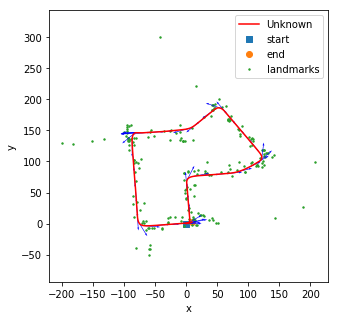

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f493668>)

In [548]:
show_result(wTi,landmarks,show_ori=True)

## Visual-Inertial SLAM

In [194]:
def circle(m):
    '''
    circle operator for m in R4, m = [s, la]T, s in R3
    '''
    s = m[:3]
    s_hat = hat_map(s)
    la = m[3]
    result = np.hstack([np.eye(3)*la,-s_hat])
    result = np.vstack([result,np.zeros([1,6])])
    return result

In [399]:
def vi_slam(t,v,w,features, K,b,cam_T_imu,w_scale = 10e-10, v_scale = 100):
    # Initialize 
    # get tau from timestamps
    tau = t[:,1:]-t[:,:-1]
    n = tau.shape[1] 
    f_size = features.shape[1] # feature length
    # discard v,w at time 0
    v = v[:,1:]
    w = w[:,1:]
    
    # constant matrices
    oTi = cam_T_imu
    M = calibration(K,b) # calibration matrix
    D = np.vstack([np.eye(3), np.zeros([1,3])]) # Dilation matrix 
    D_block = np.tile(D,[f_size,f_size]) # D block matrix
    
    # mu and cov init
    mu = np.zeros([4*f_size,1]) # long vector mu 4M
    mu_imu = np.eye(4) # mu_imu init
    cov = np.eye(3*f_size+6) # (3M+6)x(3M+6)
    mu_init = np.zeros(f_size) # to keep track if feature has been initialized
    
    # Noise
    W_noise = np.eye(6) * w_scale

    # store poses
    pose = np.zeros([4,4,n+1])
    pose_inv = np.zeros([4,4,n+1])
    pose[:,:,0] = mu_imu
    pose_inv[:,:,0] = inv(mu_imu)
    
    # loop over all timestamps for update and predict
    for i in range(n):
        # Update
        Tt = mu_imu # current iTw (mu_imu)
        f_t = features[:,:,i] # current features
        empty = np.array([-1,-1,-1,-1]) 
        v_noise = np.random.normal(0, np.sqrt(v_scale)) # noise
        for j in range(features.shape[1]):
            Hijs = [] # for storing Hij
            zt = np.array([]) # for storing zt
            zt_hat = np.array([]) # for storing zt_hat
            # get valid features
            if (f_t[:,j] != empty).all():
                # init mu if it hasn't been initialized
                if mu_init[j] == 0:
                    mu[4*j:4*(j+1),:] = p_to_w(f_t[:,j],K,b,oTi,mu_imu)
                    mu_init[j] = 1
                    cov_scale = norm(p_to_w(f_t[:,j],K,b,oTi,Tt))
                    cov[3*j:3*(j+1),3*j:3*(j+1)] = np.eye(3)* cov_scale
                # update initialized mu and cov
                else:
                    c_mu = mu[4*j:4*(j+1),:]
                    mj = f_t[:,j] + v_noise # current feature with noise
                    q = np.dot(oTi,np.dot(Tt,c_mu))
                    q_pose = np.dot(oTi,np.dot(Tt,c_mu))
                    q_circ = circle(np.dot(Tt,c_mu))
                    # store zt, zt_hat
                    #zt = np.stack([zt,f_t[:,j]])
                    zt = np.concatenate((zt, mj), axis=None)
                    zt_hat = np.concatenate((zt_hat, M.dot(projection(q))), axis=None)
                    # compute Hij (imu and vis)
                    Hij = np.dot(M.dot(proj_deriv(q)),oTi.dot(Tt.dot(D)))
                    Hij_pose = np.dot(M.dot(proj_deriv(q_pose)),oTi.dot(q_circ))
                    Hijs.append((Hij,Hij_pose,j))
        Nt = len(Hijs)
        zt = zt.reshape([4*Nt,1])
        zt_hat = zt_hat.reshape([4*Nt,1])
        # create Ht
        Ht = np.zeros([4*Nt, 3*f_size+6])
        for nt in range(Nt):
            # current Hij
            Hij_c = Hijs[nt][0]
            Hij_pose_c = Hijs[nt][1]
            m_idx = Hijs[nt][2] # landmark index
            Ht[nt*4:(nt+1)*4,3*(m_idx):3*(m_idx+1)] = Hij_c
            Ht[nt*4:(nt+1)*4,-6:] = Hij_pose_c
        Kt = get_Kt(cov,Ht,v_scale)

        
        # update mu, cov
        Kdot1 = Kt.dot(zt-zt_hat)[:3*f_size]
        Kdot2 = Kt.dot(zt-zt_hat)[-6:]
        mu = mu + D_block.dot(Kdot1)
        p = Kdot2[:3].reshape(3)
        theta = Kdot2[-3:].reshape(3)
        exp_term = rog_3_approx(p,theta)
        mu_imu = np.dot(exp_term,mu_imu)
        cov = np.dot((np.eye(3*f_size+6) - np.dot(Kt,Ht)),cov)
        # store pose
        pose[:,:,i+1] = mu_imu
        pose_inv[:,:,i+1] = inv(mu_imu)
 
        #IMU predict
        # get current v,w,tau
        w_noise = np.random.normal(0, np.sqrt(w_scale)) # noise
        v_c = v[:,i] + w_noise
        w_c = w[:,i] + w_noise
        t_c = tau[:,i]
        mu_imu = mean_predict(mu_imu,t_c,v_c,w_c)
        cov[-6:,-6:] = cov_pred(cov[-6:,-6:],t_c,v_c,w_c,W_noise)

    mu = mu.reshape([f_size,4])
    return pose, pose_inv, mu

In [549]:
slam_iTw, slam_wTi,slam_landmarks = vi_slam(t,linear_velocity,rotational_velocity,features, K,b,cam_T_imu,10e-7,100)

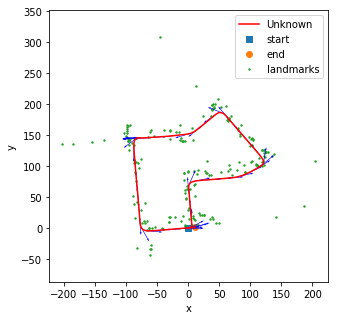

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f5626a0>)

In [550]:
show_result(slam_wTi,slam_landmarks,show_ori=True)

## Result comparison

Dataset 27

In [439]:
# low noise
filename = "./data/0027.npz"
w_scale = 10e-5
v_scale = 1000
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)
iTw, wTi = imu_predict(t,linear_velocity,rotational_velocity,w_scale)
landmarks = visual_mapping(features,iTw, K,b,cam_T_imu,v_scale)
slam_iTw, slam_wTi,slam_landmarks = vi_slam(t,linear_velocity,rotational_velocity,features, K,b,cam_T_imu,w_scale,v_scale)

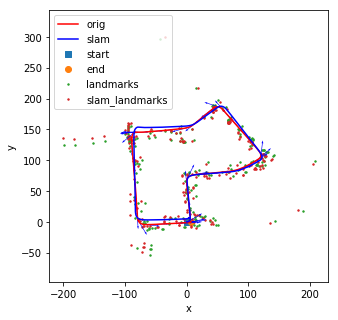

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1231222b0>)

In [440]:
compare_result(wTi,slam_wTi,landmarks,slam_landmarks,show_ori=True)

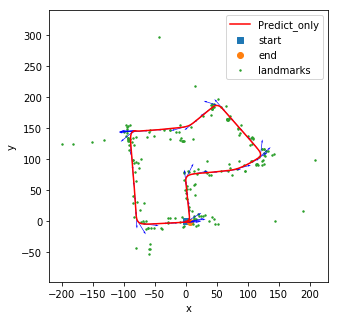

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12360b1d0>)

In [444]:
show_result(wTi,landmarks,'Predict_only',show_ori=True)

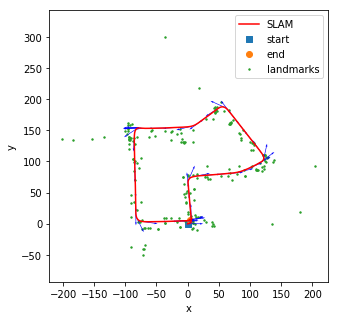

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1236f7390>)

In [445]:
show_result(slam_wTi,slam_landmarks,'SLAM',show_ori=True)

In [432]:
# high noise
filename = "./data/0027.npz"
w_scale = 10e-3
v_scale = 1000
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)
iTw, wTi = imu_predict(t,linear_velocity,rotational_velocity,w_scale)
landmarks = visual_mapping(features,iTw, K,b,cam_T_imu,v_scale)
slam_iTw, slam_wTi,slam_landmarks = vi_slam(t,linear_velocity,rotational_velocity,features, K,b,cam_T_imu,w_scale,v_scale)

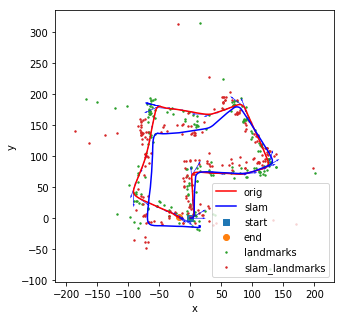

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115980ac8>)

In [433]:
compare_result(wTi,slam_wTi,landmarks,slam_landmarks,show_ori=True)

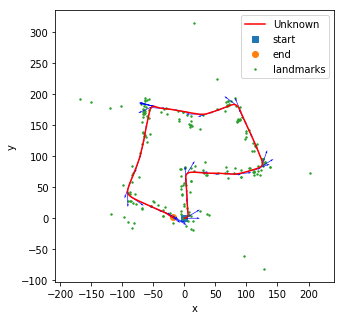

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x116132358>)

In [434]:
show_result(wTi,landmarks,show_ori=True)

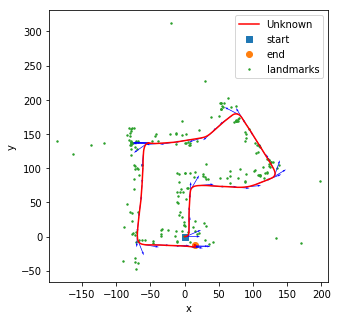

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122f90e10>)

In [435]:
show_result(slam_wTi,slam_landmarks,show_ori=True)

Dataset 42

In [500]:
# low noise
filename = "./data/0042.npz"
w_scale = 10e-7
v_scale = 1500
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)
iTw, wTi = imu_predict(t,linear_velocity,rotational_velocity,w_scale)
landmarks = visual_mapping(features,iTw, K,b,cam_T_imu,v_scale)
slam_iTw, slam_wTi,slam_landmarks = vi_slam(t,linear_velocity,rotational_velocity,features, K,b,cam_T_imu,w_scale,v_scale)

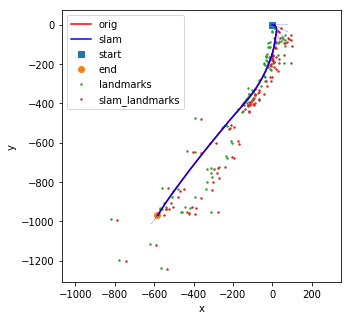

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127e69e48>)

In [501]:
compare_result(wTi,slam_wTi,landmarks,slam_landmarks,show_ori=True)

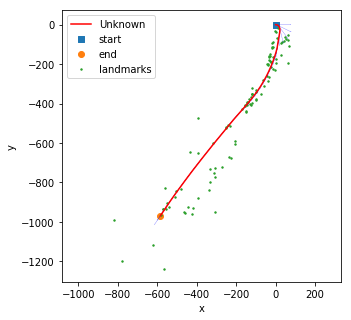

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1054a1240>)

In [502]:
show_result(wTi,landmarks,show_ori=True)

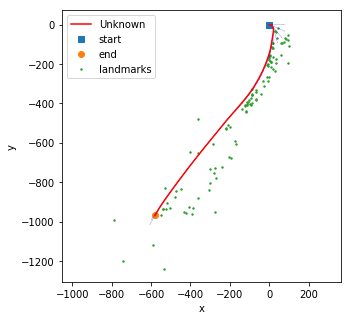

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ab143c8>)

In [503]:
show_result(slam_wTi,slam_landmarks,show_ori=True)

In [512]:
# high noise
filename = "./data/0042.npz"
w_scale = 10e-2
v_scale = 1500
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)
iTw, wTi = imu_predict(t,linear_velocity,rotational_velocity,w_scale)
landmarks = visual_mapping(features,iTw, K,b,cam_T_imu,v_scale)
slam_iTw, slam_wTi,slam_landmarks = vi_slam(t,linear_velocity,rotational_velocity,features, K,b,cam_T_imu,w_scale,v_scale)

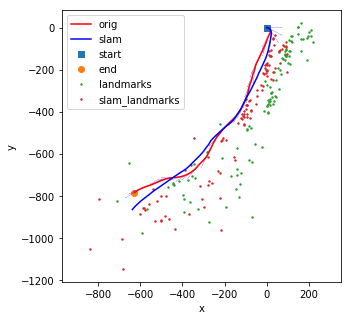

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11842c240>)

In [513]:
compare_result(wTi,slam_wTi,landmarks,slam_landmarks,show_ori=True)

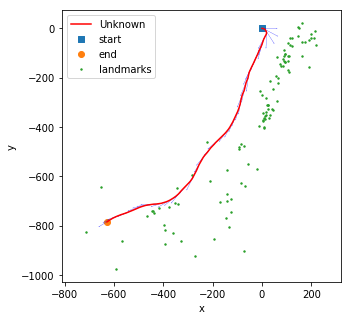

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128d5ec18>)

In [514]:
show_result(wTi,landmarks,show_ori=True)

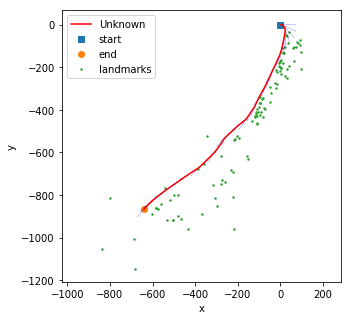

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128dd36d8>)

In [515]:
show_result(slam_wTi,slam_landmarks,show_ori=True)

Dataset 20

In [516]:
# low noise
filename = "./data/0020.npz"
w_scale = 10e-7
v_scale = 400
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)
iTw, wTi = imu_predict(t,linear_velocity,rotational_velocity,w_scale)
landmarks = visual_mapping(features,iTw, K,b,cam_T_imu,v_scale)
slam_iTw, slam_wTi,slam_landmarks = vi_slam(t,linear_velocity,rotational_velocity,features, K,b,cam_T_imu,w_scale,v_scale)

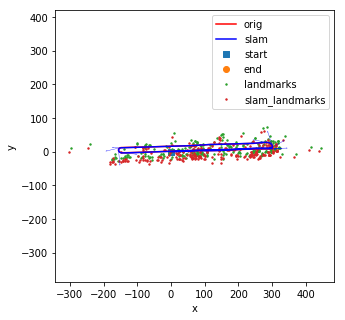

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128e51e80>)

In [517]:
compare_result(wTi,slam_wTi,landmarks,slam_landmarks,show_ori=True)

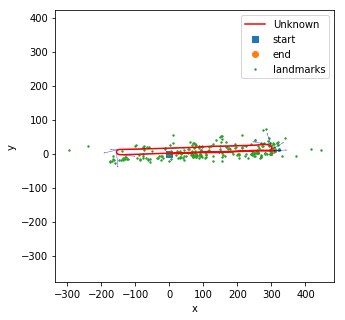

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128ef1470>)

In [518]:
show_result(wTi,landmarks,show_ori=True)

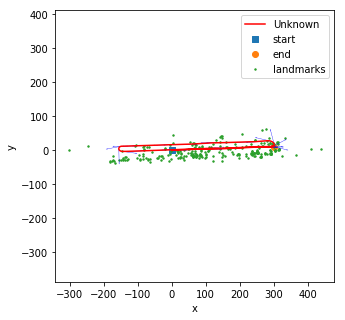

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128f606a0>)

In [519]:
show_result(slam_wTi,slam_landmarks,show_ori=True)

In [551]:
# high noise
filename = "./data/0020.npz"
w_scale = 10e-4
v_scale = 500
t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)
iTw, wTi = imu_predict(t,linear_velocity,rotational_velocity,w_scale)
landmarks = visual_mapping(features,iTw, K,b,cam_T_imu,v_scale)
slam_iTw, slam_wTi,slam_landmarks = vi_slam(t,linear_velocity,rotational_velocity,features, K,b,cam_T_imu,w_scale,v_scale)

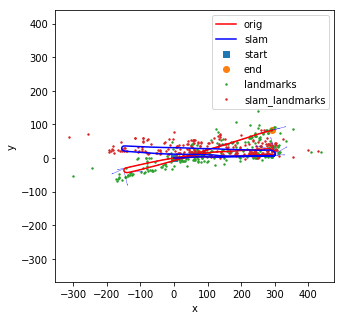

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f67fd30>)

In [552]:
compare_result(wTi,slam_wTi,landmarks,slam_landmarks,show_ori=True)

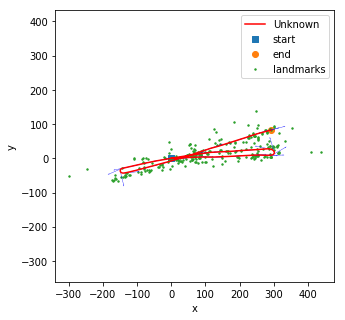

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f7a7b00>)

In [553]:
show_result(wTi,landmarks,show_ori=True)

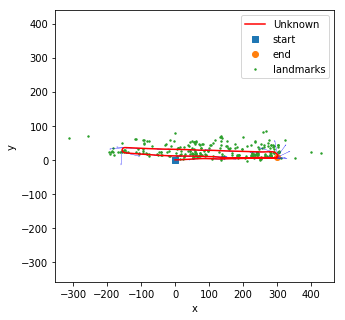

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f8c5cf8>)

In [554]:
show_result(slam_wTi,slam_landmarks,show_ori=True)